In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import string # string manipulation
import re # regular expressions
import nltk # text manipulation

from tqdm import trange # progress bar
from nltk import tokenize # text manipulation
from nltk.corpus import stopwords # text manipulation
from nltk.stem import WordNetLemmatizer # text manipulation
from nltk.probability import FreqDist # text manipulation
from collections import Counter # text manipulation
from sklearn.feature_extraction.text import CountVectorizer # text manipulation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # wordcloud generator
from IPython.display import display # image display
from PIL import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import tree

import joblib # guardar modelos

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from utils.funciones import *

### Importando datos

In [2]:
data_original = pd.read_csv("threads.csv") # carga del dataset a usar como variable

In [3]:
data = data_original.copy()

In [4]:
# Pasaremos las fechas a formato datetime
# Dias
data['review_date'] = pd.to_datetime(data['review_date']).apply(lambda x: (x.value)//(1_000_000_000*60*60*24))
# normalizar 0 a 1  las fechas
data['review_date'] = (data['review_date'] - data['review_date'].min()) / (data['review_date'].max() - data['review_date'].min())

# Pasaremos algunas columnas a categoricas source, rating a int
data['source'] = data['source'].apply(lambda x: 1 if x == "Google Play" else 0)

# verifiquemos los tipos de columna
data.head(10)

,source,review_description,rating,review_date
0,1,Meh. Not the greatest experience on a Chromebo...,2,0.15
1,1,Pretty good for a first launch!! Its easy to u...,3,0.70
2,1,"For a brand new app, it's very well optimized....",3,0.05
3,1,"Great app with a lot of potential! However, th...",3,0.25
4,1,"The app is good, but it needs a lot of functio...",3,0.05
5,1,"Currently, it's very challenging to use. It's ...",2,0.65
6,1,I still don’t want to see content from people ...,1,0.70
7,1,Could be great if all pages loaded when you cl...,2,0.05
8,1,I'm liking the concept! There is room for impr...,3,0.20
9,1,Not bad! This is its first launch. There is st...,5,0.05


## Calificación / Fecha

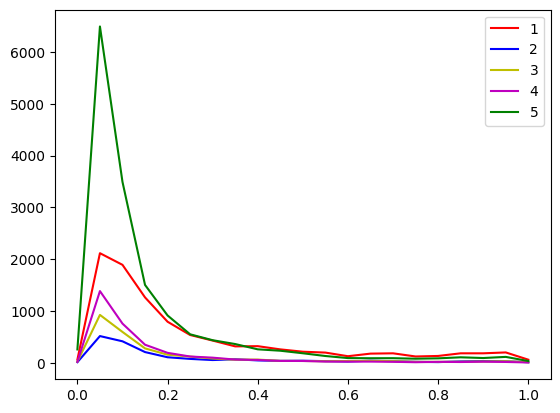

In [5]:
fechas = []
calificaciones = [[],[],[],[],[]]

r_date = data["review_date"]
rating = data["rating"]

for i in range(len(r_date)):
    if r_date[i] not in fechas:
        fechas.append(r_date[i])
        calificaciones[(rating[i]-1)%5].append(1) ## posicion buscada
        for k in range(4): 
            calificaciones[(rating[i]+k)%5].append(0)
    else:
        index = fechas.index(r_date[i])
        calificaciones[(rating[i]-1)%5][index] += 1
        
colores = "rbymg"
for k in range(5):
    sorted_pairs = sorted(zip(fechas, calificaciones[k]))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, linestyle="-", color=colores[k], label=str(k+1))

plt.legend()
plt.show()

Se relaciona la calificacion con las fechas?

Probablemente si, vemos que la mayoria de las reviews se centran en una fecha en especifico.

# Clasificación

In [7]:
data = data_original.copy()
r_date = data["review_date"]
source = data["source"]
rating = data["rating"]

data.drop("review_date", axis=1, inplace=True)
data.drop("source", axis=1, inplace=True)

# creacion del grafico de pie de las reviews segun rating
data["rating"] = data["rating"].apply(ratingTransform)

,review_description,rating
0,Meh. Not the greatest experience on a Chromebo...,NEGATIVE
1,Pretty good for a first launch!! Its easy to u...,NEUTRAL
2,"For a brand new app, it's very well optimized....",NEUTRAL
3,"Great app with a lot of potential! However, th...",NEUTRAL
4,"The app is good, but it needs a lot of functio...",NEUTRAL
5,"Currently, it's very challenging to use. It's ...",NEGATIVE
6,I still don’t want to see content from people ...,NEGATIVE
7,Could be great if all pages loaded when you cl...,NEGATIVE
8,I'm liking the concept! There is room for impr...,NEUTRAL
9,Not bad! This is its first launch. There is st...,POSITIVE


## Vectorizar

In [8]:
# Extraer los vectores
vectorizer = CountVectorizer(preprocessor=preprocesar, min_df=2)
vectors = vectorizer.fit_transform(data["review_description"])

# Incorporar los vectores como dataframe
X = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
y = data["rating"]

data_vectorizado = pd.concat([y, X], axis=1)

# Entrenando modelos

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=37,stratify=y)

print("Cantidad de instancias por clase en el train:")
print("Clase POSITIVE: " + str((y_train=="POSITIVE").sum()))
print("Clase NEUTRAL: " + str((y_train=="NEUTRAL").sum()))
print("Clase NEGATIVE: " + str((y_train=="NEGATIVE").sum()))

## ==> Clases desbalanceadas

Cantidad de instancias por clase en el train:
Clase POSITIVE: 10424
Clase NEUTRAL: 3905
Clase NEGATIVE: 7720


In [9]:
#Model con datos desbalanceados
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_DecisionTreeClassifier.joblib")

In [91]:
#Model con datos desbalanceados (mejor opcion)
clf = DecisionTreeClassifier(criterion="gini", max_depth=10)
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_DTC_best.joblib")

['modelos/trained_DTC_best.joblib']

In [95]:
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_base_dummy.joblib")

['modelos/trained_base_dummy.joblib']

In [98]:
clf = GaussianNB()
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_gaussian_nb.joblib")

['modelos/trained_gaussian_nb.joblib']

In [100]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_knclassifier.joblib")

['modelos/trained_knclassifier.joblib']

In [101]:
clf = SVC()
clf.fit(X_train, y_train)
joblib.dump(clf, "modelos/trained_svc.joblib")

['modelos/trained_svc.joblib']

# Cargando los modelos

In [89]:
clf = joblib.load("modelos/trained_DecisionTreeClassifier.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

Accuracy en test set: 0.659331553263972
              precision    recall  f1-score   support

    NEGATIVE       0.71      0.63      0.67      3802
     NEUTRAL       0.36      0.22      0.27      1924
    POSITIVE       0.69      0.84      0.76      5135

    accuracy                           0.66     10861
   macro avg       0.59      0.57      0.57     10861
weighted avg       0.64      0.66      0.64     10861



In [92]:
clf = joblib.load("modelos/trained_DTC_best.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

Accuracy en test set: 0.5650492588159469
              precision    recall  f1-score   support

    NEGATIVE       0.67      0.32      0.43      3802
     NEUTRAL       0.44      0.04      0.07      1924
    POSITIVE       0.55      0.94      0.69      5135

    accuracy                           0.57     10861
   macro avg       0.55      0.43      0.40     10861
weighted avg       0.57      0.57      0.49     10861



In [104]:
clf = joblib.load("modelos/trained_base_dummy.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

Accuracy en test set: 0.38219316821655464
              precision    recall  f1-score   support

    NEGATIVE       0.36      0.36      0.36      3802
     NEUTRAL       0.18      0.18      0.18      1924
    POSITIVE       0.47      0.47      0.47      5135

    accuracy                           0.38     10861
   macro avg       0.34      0.34      0.34     10861
weighted avg       0.38      0.38      0.38     10861



In [105]:
clf = joblib.load("modelos/trained_gaussian_nb.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

Accuracy en test set: 0.5450695147776448
              precision    recall  f1-score   support

    NEGATIVE       0.71      0.20      0.32      3802
     NEUTRAL       0.26      0.39      0.31      1924
    POSITIVE       0.64      0.86      0.73      5135

    accuracy                           0.55     10861
   macro avg       0.54      0.48      0.45     10861
weighted avg       0.60      0.55      0.51     10861



In [ ]:
clf = joblib.load("modelos/trained_knclassifier.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

In [110]:
clf = joblib.load("modelos/trained_svc.joblib")
y_pred = clf.predict(X_test)   ## Predecimos con nuevos datos (los de test X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))   ## Evaluamos la predicción comparando y_test con y_pred
print(classification_report(y_test, y_pred))

### Visualizando desicion tree classifier

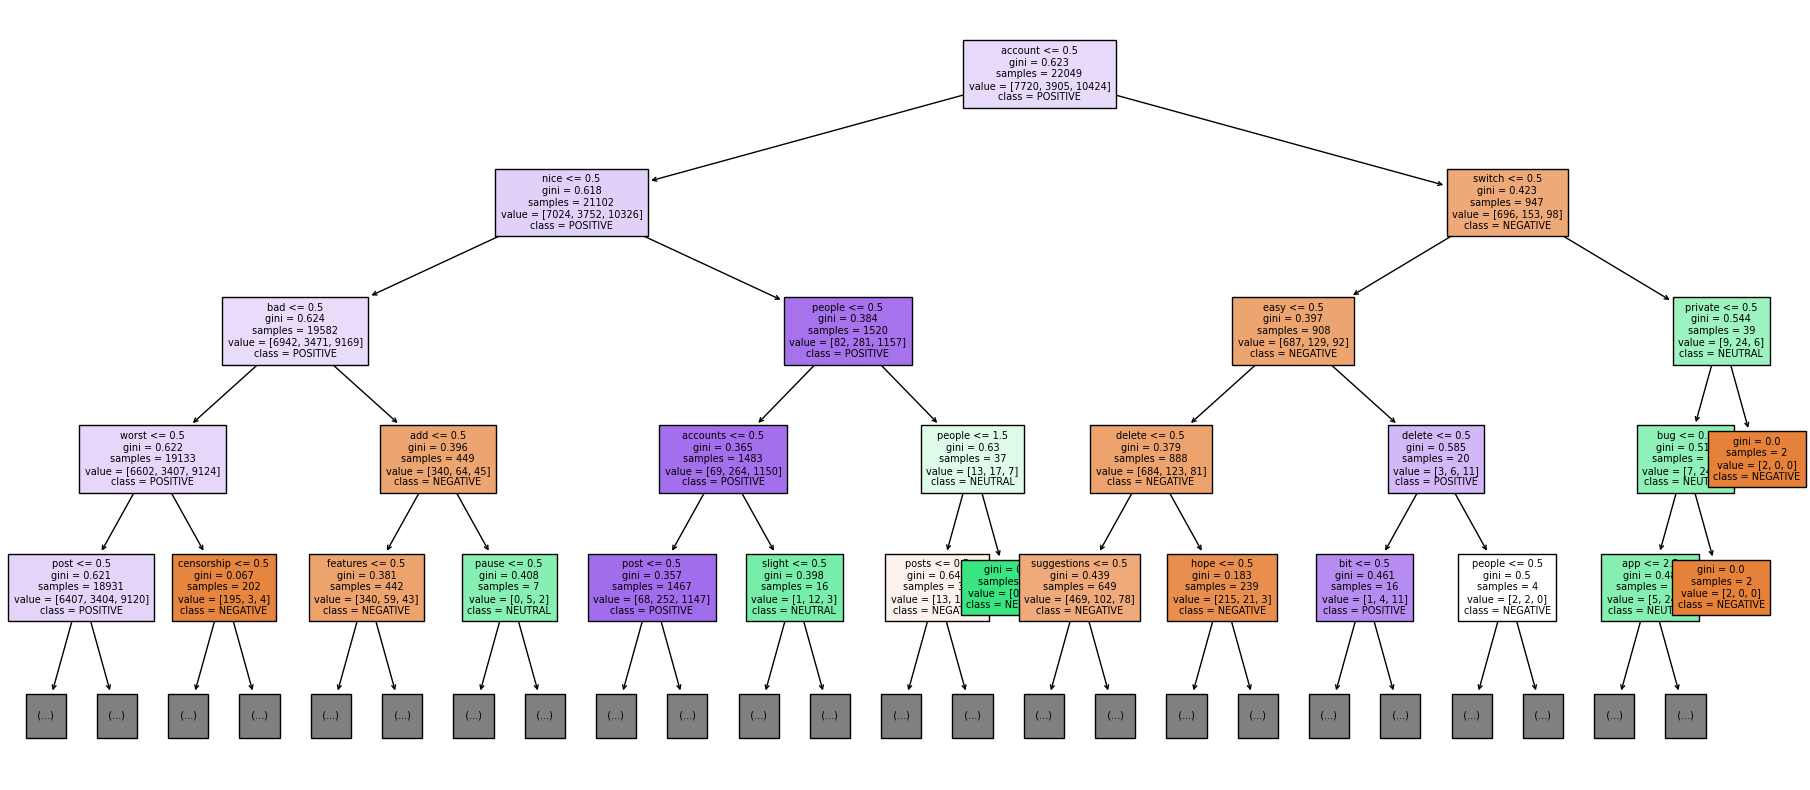

In [15]:
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 4, feature_names=list(vectorizer.get_feature_names_out()), class_names=list(clf.classes_), filled=True)
plt.show()

### Ranking de las palabras con más importancia

In [60]:
importances = clf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")

for f in range(5):
    print(f"{str(f+1)+'.':<{4}}{feature_names[indices[f]]:<{13}}{(importances[indices[f]])}")


Feature ranking:
1.  account      0.027683899791132015
2.  nice         0.02442142944832581
3.  app          0.01411846829145034
4.  people       0.013542857762130727
5.  bad          0.01340061358160061


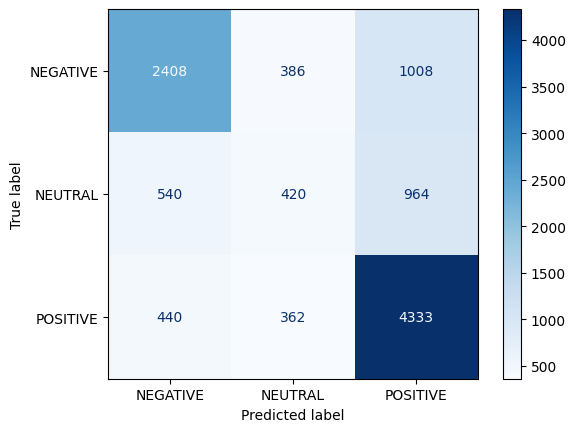

In [78]:
conf_m = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=list(clf.classes_))
disp.plot(cmap="Blues", values_format='')

# Validacion Cruzada

In [80]:
clf = DecisionTreeClassifier(random_state=42)
scoring = ['accuracy', 'f1_macro']
cv_results = cross_validate(clf,
                            X,y,
                            cv=5,
                            scoring=scoring,
                            return_train_score=True,
                            return_estimator=True)

print('Promedio Accucary:', np.mean(cv_results['test_accuracy']))
print('Promedio F1-score:', np.mean(cv_results['test_f1_macro']))

Promedio Accucary: 0.6268915223336371
Promedio F1-score: 0.5332531996220004


In [82]:

tuned_parameters = {'criterion': ['gini','entropy'],
                    'max_depth': [2, 3, 5, 10]}

#Construir el clf con GridSearch y luego entrenar
clf = GridSearchCV(DecisionTreeClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring='f1_macro')

clf.fit(X_train, y_train)

print("Mejor combinación de parámetros:")
print(clf.best_params_)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 10}
              precision    recall  f1-score   support

    NEGATIVE       0.67      0.32      0.43      3802
     NEUTRAL       0.44      0.04      0.07      1924
    POSITIVE       0.55      0.94      0.69      5135

    accuracy                           0.57     10861
   macro avg       0.55      0.43      0.40     10861
weighted avg       0.57      0.57      0.49     10861

